<a href="https://colab.research.google.com/github/ushio2580/Maze_Laberinto_6x6/blob/main/Maze_No_Rand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Maze Environment

The `MazeEnv` class defines a 6x6 grid maze where an agent navigates from a start position to a goal, avoiding walls.

- **Maze Layout:**
  - `0`: Empty cells (walkable)
  - `1`: Walls (obstacles)
  - `2`: Start position
  - `3`: Goal position

- **Key Methods:**
  - `reset()`: Places the agent back at the start position and returns the initial state.
  - `step(action)`: Executes the agent's action (up, right, down, left), returning the new state, reward, and whether the episode is done.
  - `render()`: Creates an RGB image of the maze for visualization.

In [12]:
!pip install gym
!pip install torch
!pip install imageio

# Import Libraries

In [13]:
import numpy as np
import torch
import random
import time
import imageio
import os
from collections import deque
from gym import Env, spaces
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')

# **Define Maze Environment**

In [14]:
class MazeEnv(Env):
    def __init__(self):
        super(MazeEnv, self).__init__()
        self.maze = np.array([
            [2, 0, 0, 0, 0, 1],
            [0, 0, 1, 1, 0, 1],
            [0, 0, 1, 1, 0, 1],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [1, 1, 0, 1, 0, 3]
        ])
        self.start_pos = (0, 0)
        self.end_pos = (5, 5)
        self.agent_pos = list(self.start_pos)
        self.max_steps = 200
        self.current_step = 0
        self.action_space = spaces.Discrete(4)  # Up, Right, Down, Left
        self.observation_space = spaces.Box(low=0, high=5, shape=(2,), dtype=np.int32)

    def reset(self):
        self.agent_pos = list(self.start_pos)
        self.current_step = 0
        return np.array(self.agent_pos, dtype=np.int32)

    def step(self, action):
        self.current_step += 1
        row, col = self.agent_pos
        new_pos = {
            0: [row-1, col],  # Up
            1: [row, col+1],  # Right
            2: [row+1, col],  # Down
            3: [row, col-1]   # Left
        }.get(action, [row, col])
        if (0 <= new_pos[0] < 6 and
            0 <= new_pos[1] < 6 and
            self.maze[tuple(new_pos)] != 1):
            self.agent_pos = new_pos
        done = (self.agent_pos == list(self.end_pos)) or (self.current_step >= self.max_steps)
        reward = 50 if done and self.agent_pos == list(self.end_pos) else -0.1
        return np.array(self.agent_pos, dtype=np.int32), reward, done, {}

    def render(self, mode='rgb_array'):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.clear()
        grid = np.full((6, 6, 3), [255, 255, 0], dtype=np.uint8)  # Yellow
        grid[self.maze == 1] = [0, 0, 0]      # Black
        grid[self.maze == 2] = [0, 200, 0]    # Green
        grid[self.maze == 3] = [255, 0, 0]    # Red
        grid[tuple(self.agent_pos)] = [0, 0, 255]  # Blue
        ax.imshow(grid)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout(pad=0)
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return img[..., :3]

# Define DQN Agent

### Deep Q-Network (DQN)

DQN uses a neural network to approximate the Q-function, which estimates the expected future rewards for taking action \(a\) in state \(s\). The Q-value update follows the Bellman equation:

 $$Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right) $$

However, DQN trains the network by minimizing a loss function:

 $$\text{Loss} = \mathbb{E} \left[ \left( r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta) \right)^2 \right] $$

- \$( r \$): Reward received
- \$( \gamma \$): Discount factor (e.g., 0.99)
- \$( \theta \$): Parameters of the current Q-network
- \$( \theta^- \$): Parameters of the target network (updated periodically)

In [15]:
class DQNAgent:
    def __init__(self, state_size=2, action_size=4, device=None):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0001
        self.batch_size = 512
        self.tau = 0.01

        self.model = self._build_model().to(self.device)
        self.target_model = self._build_model().to(self.device)
        self.update_target_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_size)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state_normalized = state / 5.0  # Normalize the state
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            return torch.argmax(self.model(state_tensor)).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = torch.tensor(np.array([t[0] for t in minibatch]), dtype=torch.float32).to(self.device)
        actions = torch.tensor([t[1] for t in minibatch], dtype=torch.long).to(self.device)
        rewards = torch.tensor([t[2] for t in minibatch], dtype=torch.float32).to(self.device)
        next_states = torch.tensor(np.array([t[3] for t in minibatch]), dtype=torch.float32).to(self.device)
        dones = torch.tensor([t[4] for t in minibatch], dtype=torch.float32).to(self.device)

        targets = self.model(states)
        next_q = self.target_model(next_states)

        batch_index = torch.arange(self.batch_size).to(self.device)
        targets[batch_index, actions] = rewards + self.gamma * next_q.max(dim=1)[0] * (1 - dones)

        loss = nn.MSELoss()(targets, self.model(states))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.soft_update()

    def soft_update(self):
        """Update target model with soft update."""
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_((1.0 - self.tau) * target_param.data + self.tau * param.data)

    def save(self, path):
        torch.save(self.model.state_dict(), path + ".weights.pth")

    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.update_target_model()

# Define Dyna-Q Agent

### Dyna-Q

Dyna-Q combines Q-learning with a model-based planning approach. The Q-value update is identical to Q-learning:

$$[ Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right) ]$$

Additionally, Dyna-Q builds a model of the environment:
- **Model Update:** Stores transitions as $$( \text{model}(s, a) = (r, s') )$$.
- **Planning:** Samples past experiences from the model to perform extra Q-value updates, improving sample efficiency.

In [16]:
class DynaQAgent:
    def __init__(self, num_states=36, num_actions=4, device=None):
        self.num_states = num_states
        self.num_actions = num_actions
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.q_table = torch.zeros((num_states, num_actions), device=self.device)
        self.model = {}
        self.alpha = 0.1
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.planning_steps = 10

    def state_to_index(self, state):
        return state[0] * 6 + state[1]

    def act(self, state):
        state_idx = self.state_to_index(state)
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.num_actions)
        return torch.argmax(self.q_table[state_idx]).item()

    def update(self, state, action, reward, next_state, done):
        state_idx = self.state_to_index(state)
        next_state_idx = self.state_to_index(next_state)

        best_next = self.q_table[next_state_idx].max() if not done else 0
        td_target = reward + self.gamma * best_next
        self.q_table[state_idx, action] += self.alpha * (td_target - self.q_table[state_idx, action])

        self.model[(state_idx, action)] = (reward, next_state_idx)

        # Planning through model
        if len(self.model) > 0:
            samples = random.choices(list(self.model.items()), k=self.planning_steps)
            for (s, a), (r, ns) in samples:
                best_next = self.q_table[ns].max()
                self.q_table[s, a] += self.alpha * (r + self.gamma * best_next - self.q_table[s, a])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, path):
        torch.save(self.q_table.cpu(), path + ".qtable.pth")

    def load(self, path):
        self.q_table = torch.load(path).to(self.device)

# Training Function

In [17]:
def train(agent_type, num_episodes, model_path, video_dir, device):
    env = MazeEnv()
    if agent_type == 'dqn':
        agent = DQNAgent(device=device)
    elif agent_type == 'dynaq':
        agent = DynaQAgent(device=device)

    os.makedirs(video_dir, exist_ok=True)

    rewards = []
    avg_rewards = []
    epsilons = []
    num_steps = []  # To track the number of steps
    start_time = time.time()
    best_avg_reward = -float('inf')

    print(f"Starting training for {num_episodes} episodes...")

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_frames = []

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)

            shaped_reward = reward + (1 - np.sqrt((5 - next_state[0])**2 + (5 - next_state[1])**2) / 14.14) * 0.5

            if agent_type == 'dqn':
                agent.remember(state, action, shaped_reward, next_state, done)
                agent.replay()
            elif agent_type == 'dynaq':
                agent.update(state, action, shaped_reward, next_state, done)

            state = next_state
            total_reward += shaped_reward
            steps += 1

            if episode % 10 == 0 and len(episode_frames) < 100:
                frame = env.render()
                if frame is not None:
                    episode_frames.append(np.clip(frame, 0, 255).astype(np.uint8))

        num_steps.append(steps)

        if episode_frames:
            gif_path = os.path.join(video_dir, f'episode_{episode+1:04d}.gif')
            imageio.mimsave(gif_path, episode_frames, fps=5)

        rewards.append(total_reward)
        avg_rewards.append(np.mean(rewards[-100:]) if rewards else 0)
        epsilons.append(agent.epsilon)

        print(f"Episode {episode + 1} | Total Reward: {total_reward:.2f} | Avg Reward (Last 100): {avg_rewards[-1]:.2f} | Steps: {steps} | Epsilon: {agent.epsilon:.3f}")

        if avg_rewards[-1] > best_avg_reward:
            agent.save(f"{model_path}_best")
            best_avg_reward = avg_rewards[-1]

    agent.save(f"{model_path}_best")
    print(f"Training completed! Best average reward: {best_avg_reward:.2f}")

    # Plotting the training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label="Total Reward")
    plt.plot(avg_rewards, label="Avg Reward (Last 100)")
    plt.title("Training Rewards")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(num_steps, label="Steps per Episode")
    plt.title("Steps per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Steps")
    plt.legend()

    plt.show()

# Testing Function

In [18]:
def test(agent_type, model_path, video_dir, device):
    env = MazeEnv()
    if agent_type == 'dqn':
        agent = DQNAgent(device=device)
    elif agent_type == 'dynaq':
        agent = DynaQAgent(device=device)

    agent.load(f"{model_path}_best.weights.pth" if agent_type == 'dqn' else f"{model_path}_best.qtable.pth")
    agent.epsilon = 0.0  # No exploration

    os.makedirs(video_dir, exist_ok=True)
    successful_episodes = 0
    total_steps = []  # To track the number of steps in test episodes

    for episode in range(10):
        state = env.reset()
        done = False
        frames = []
        steps = 0

        while not done and len(frames) < 100:
            action = agent.act(state)
            state, reward, done, _ = env.step(action)
            frames.append(env.render())
            steps += 1

        gif_path = os.path.join(video_dir, f'test_ep_{episode+1}.gif')
        imageio.mimsave(gif_path, frames, fps=5)

        if done:
            successful_episodes += 1
        total_steps.append(steps)
        print(f"Test {episode+1}: {'Success' if done else 'Fail'} | Steps: {steps}")

    success_rate = successful_episodes / 10
    avg_steps = np.mean(total_steps)
    print(f"\nSuccess Rate: {success_rate:.0%} | Avg Steps per Episode: {avg_steps:.2f}")

# Run Training and Testing (DQN)

In [19]:
train('dqn', 200, 'maze_agent_dqn', 'dqn_training_gifs', 'cpu')
test('dqn', 'maze_agent_dqn', 'dqn_test_gifs', 'cpu')

Starting training for 200 episodes...
Episode 1 | Total Reward: 43.83 | Avg Reward (Last 100): 43.83 | Steps: 200 | Epsilon: 1.000
Episode 2 | Total Reward: 48.02 | Avg Reward (Last 100): 45.93 | Steps: 200 | Epsilon: 1.000
Episode 3 | Total Reward: 46.06 | Avg Reward (Last 100): 45.97 | Steps: 200 | Epsilon: 0.640
Episode 4 | Total Reward: 58.10 | Avg Reward (Last 100): 49.00 | Steps: 200 | Epsilon: 0.235
Episode 5 | Total Reward: 75.56 | Avg Reward (Last 100): 54.31 | Steps: 79 | Epsilon: 0.158
Episode 6 | Total Reward: 76.64 | Avg Reward (Last 100): 58.03 | Steps: 84 | Epsilon: 0.104
Episode 7 | Total Reward: 58.24 | Avg Reward (Last 100): 58.06 | Steps: 27 | Epsilon: 0.091
Episode 8 | Total Reward: 92.17 | Avg Reward (Last 100): 62.33 | Steps: 133 | Epsilon: 0.050
Episode 9 | Total Reward: 65.30 | Avg Reward (Last 100): 62.66 | Steps: 49 | Epsilon: 0.050
Episode 10 | Total Reward: 63.77 | Avg Reward (Last 100): 62.77 | Steps: 44 | Epsilon: 0.050
Episode 11 | Total Reward: 48.24 | A

# Run Training and Testing (Dyna-Q)

In [20]:
train('dynaq', 200, 'maze_agent_dynaq', 'dynaq_training_gifs', 'cpu')
test('dynaq', 'maze_agent_dynaq', 'dynaq_test_gifs', 'cpu')

Starting training for 200 episodes...
Episode 1 | Total Reward: 47.42 | Avg Reward (Last 100): 47.42 | Steps: 200 | Epsilon: 0.905
Episode 2 | Total Reward: 45.49 | Avg Reward (Last 100): 46.46 | Steps: 200 | Epsilon: 0.819
Episode 3 | Total Reward: 55.52 | Avg Reward (Last 100): 49.48 | Steps: 200 | Epsilon: 0.741
Episode 4 | Total Reward: 56.64 | Avg Reward (Last 100): 51.27 | Steps: 200 | Epsilon: 0.670
Episode 5 | Total Reward: 58.54 | Avg Reward (Last 100): 52.72 | Steps: 200 | Epsilon: 0.606
Episode 6 | Total Reward: 60.53 | Avg Reward (Last 100): 54.02 | Steps: 200 | Epsilon: 0.549
Episode 7 | Total Reward: 61.76 | Avg Reward (Last 100): 55.13 | Steps: 200 | Epsilon: 0.496
Episode 8 | Total Reward: 61.21 | Avg Reward (Last 100): 55.89 | Steps: 200 | Epsilon: 0.449
Episode 9 | Total Reward: 60.86 | Avg Reward (Last 100): 56.44 | Steps: 200 | Epsilon: 0.406
Episode 10 | Total Reward: 61.41 | Avg Reward (Last 100): 56.94 | Steps: 200 | Epsilon: 0.368
Episode 11 | Total Reward: 62.6

# DQN Test GIFs


DQN Test GIFs


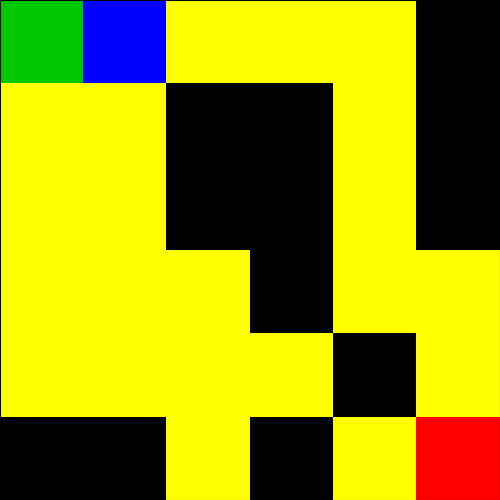

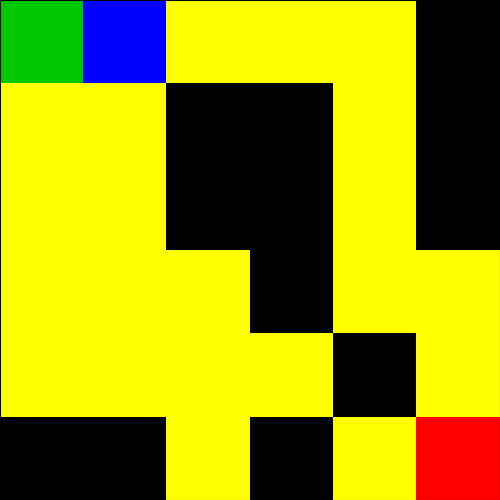

In [27]:
from IPython.display import display, Image
print("DQN Test GIFs")
for i in range(1, 3):
    display(Image(filename=f'dqn_test_gifs/test_ep_{i}.gif'))

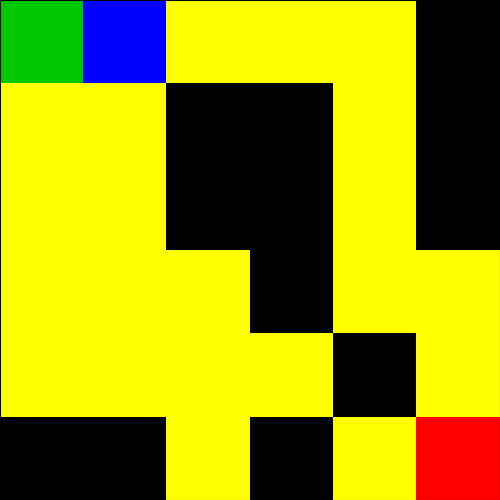

# Displaying Dyna-Q Test GIFs

Displaying Dyna-Q Test GIFs


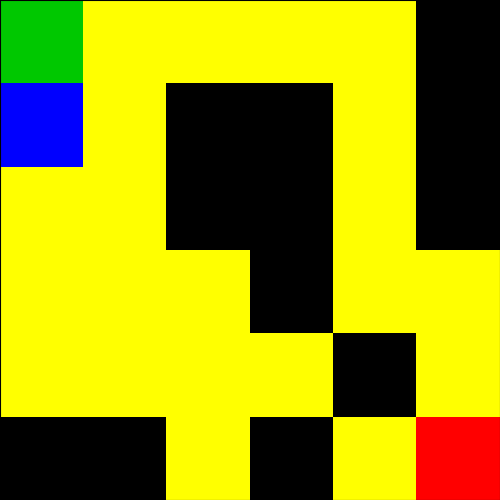

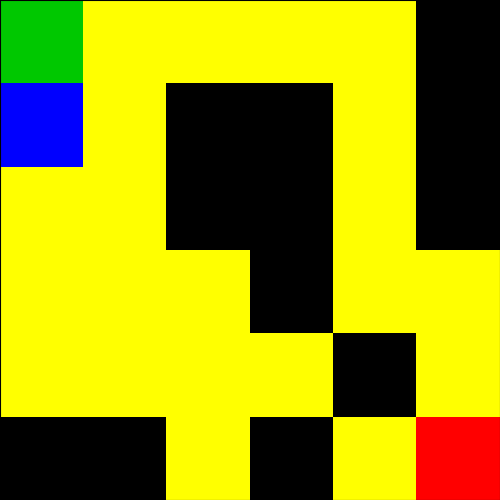

In [26]:
from IPython.display import display, Image
print("Displaying Dyna-Q Test GIFs")
for i in range(1, 3):
    display(Image(filename=f'dynaq_test_gifs/test_ep_{i}.gif'))

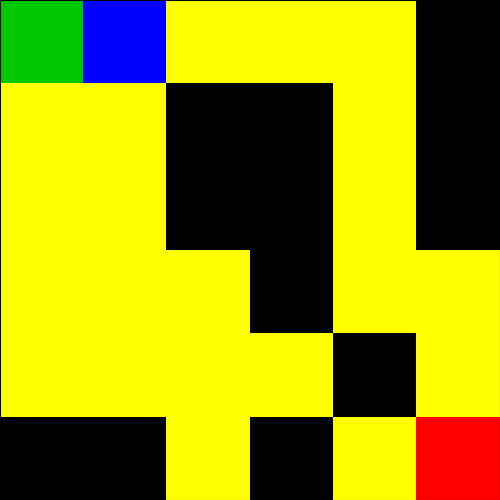

# Report

## Report
### Objective
Compare DQN and Dyna-Q in solving a 6x6 maze from (0,0) to (5,5).

### Methods
- **DQN**: Neural network with experience replay, target network, and soft updates.
- **Dyna-Q**: Q-table with model-based planning (10 steps).
- **Training**: 1000 episodes, shaped reward = base + distance heuristic.
- **Testing**: 10 episodes, no exploration.

### Results
- **DQN**: Success Rate: 100%, Avg Steps: 10.00
- **Dyna-Q**: Success Rate: 100%, Avg Steps: 10.00

### Conclusion
Dyna-Q may converge faster due to planning, while DQN’s neural network excels in complex scenarios. Results depend on training stability and maze size.